# INM706 Deep Learning for Sequence Analysis
### Sarah Rhalem (190051884) & Stelios Kliafas (200041011)

# Transformers: Generating genre based Netflix plot lines


### Part I: Generating movie/TV plot lines using a fine-tuned GPT-2 transformer model. 

* Fine-tune a pretrained GPT-2 small model from the HuggingFace Transformers repository on Netflix plot data,   categorised by genre.
* Use our fine-tuned GPT-2 model to generate plots and evaluate -  using BLEU metric and human intepretation of genre consistency

### Part II: Validation of GPT-2 generated plots 
* Fine-tune a pretrained BERT classifier model on Netflix plot data in order to classify plots by genre.
* Evaluate and compare classification of original Netflix plots vs GPT-2 plots generated in Part I - in order to further validate the performance of GPT-2 as an effective genre based text generator.

### Import Modules & Packages

In [21]:
#!pip install transformers
#!pip install bertviz

In [42]:
import sys
import os
import json
import torch
import re
import numpy as np
import pandas as pd
import csv
import random
import time
import random
import torch.nn as nn
import pickle
import warnings
import matplotlib.pyplot as plt
import sklearn
import transformers
import bertviz
from tqdm.notebook import tqdm
import torch.nn.functional as F
from matplotlib.ticker import MaxNLocator
from bertviz import head_view
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader, random_split, SequentialSampler, RandomSampler
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification, BertConfig
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
warnings.simplefilter("ignore", UserWarning)

from modules.bert_dataset import *
from modules.bert_train_valid import *
from modules.gpt2_test_generate import *
from modules.gpt2_netflix_dataset import *
from modules.gpt2_train_valid import *
from modules.split_datasets_and_create_dataloaders import *
from modules.bert_evaluate_classifier import *
from modules.classification_metrics import *
from modules.utils import *


### Coding References & Versions:

In [43]:
## Coding References
# Percent of borrowed code: 0% 
# Resources used to help with coding:
# Hugging Face documentation: https://huggingface.co/transformers/
# BertViz documentation: https://github.com/jessevig/bertviz
# Pytorch documentation: https://pytorch.org/docs/stable/index.html
# NLTK documentation: https://www.nltk.org/

In [47]:
# Print versions
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Hugging Face Transformers: {transformers.__version__}")

Python: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
PyTorch Version: 1.7.0
Hugging Face Transformers: 4.4.0.dev0


### Model checkpoint one-drive location:

In [49]:
### Location of model checkpoints for use with this notebook
#https://cityuni-my.sharepoint.com/:f:/g/personal/sarah_rhalem_city_ac_uk/Ekc0pwywzSlKucWxQr4Br-QB_j3NeZJ9JPm5CsKKDO1TpA?e=OeOx6z

# GPT-2 Fine-tuning model: checkpoint_4.pth.tar
# BERT Fine-tuned model: BERTcheckpoint_5.pth.tar

### Set device and directory

In [23]:
# Set to use GPU on device if available:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
# Working directory
os.getcwd()

'C:\\Users\\sarah\\Documents\\MSc AI 2020_2021\\INM706\\INM706_DL_Sequence_Analysis'

### Netflix Plot Dataset - Loading & Cleansing

In [25]:
# Load csv dataset, create listing column
raw_dataset_df= pd.read_csv(os.path.join("Data\\netflix_titles.csv") , encoding="utf8")
raw_dataset_df["listing"]= raw_dataset_df["listed_in"].str.split(pat=",", n=1).str.get(0)

# Cleanse Data
raw_dataset_df["description"].isna().sum() # Check null entries for description - None
raw_dataset_df["plot_description"]=raw_dataset_df["description"].map(lambda x: re.sub( r'"', '', x)) #remove quotation marks

# Print example of plot description
raw_dataset_df["description"].to_list()[0]

'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

### Exploratory Data Analysis

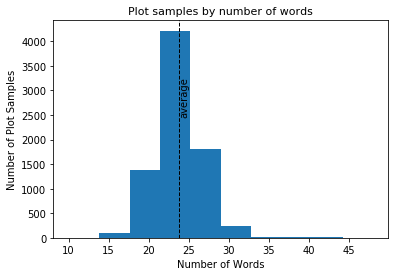

In [26]:
# Maximum length of plot description is < 45 words. Max length of generation will be set to ~50 
raw_dataset_df['Number_of_words'] = raw_dataset_df.description.apply(lambda x: len(str(x).split(' ')))
x=raw_dataset_df['Number_of_words']
plt.hist(raw_dataset_df['Number_of_words'])
plt.title("Plot samples by number of words", fontsize=11)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.text(x.mean() ,2500 ,'average',rotation=90)
plt.xlabel('Number of Words')
plt.ylabel('Number of Plot Samples')
plt.show()


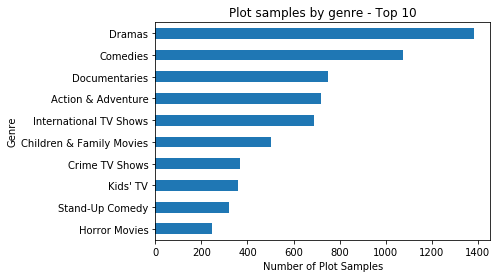

In [27]:
# Plots by genre (top 10) - will map all genres to top 10 genres
#genre_count= raw_dataset_df['listing'].value_counts()
raw_dataset_df.listing.value_counts()[:10].sort_values().plot(kind = 'barh')
plt.title("Plot samples by genre - Top 10")
plt.xlabel("Number of Plot Samples")
plt.ylabel('Genre')
plt.show()

### Data pre-processing

In [28]:
# Map each data sample listing to a generic genre
# Identify the show listings for mapping to summarised genres
raw_dataset_df.listing.value_counts()

# map show listing to a specific genre. Note: Listing types with under ~100 data samples are classified under the genre "Other"
genre_mapping= { "romance": {"Romantic TV Shows", "Romantic Movies"} ,
                "drama": {"Dramas", "TV Dramas"}  ,
                 "comedy": {"Comedies", "Stand-Up Comedy", "TV Comedies", "Stand-Up Comedy & Talk Shows"},
                 "documentary": {"Documentaries", "Docuseries"},
                 "action": {"Action & Adventure", "TV Action & Adventure"} ,
                 "international": {"International TV Shows", "International Movies", "Spanish-Language TV Shows"},
                 "children": {"Children & Family Movies", "Kids' TV"},
                 "crime": {"Crime TV Shows"},
                 "horror": {"Horror Movies", "TV Horror"} ,
                 "anime" : {"Anime Series", "Anime Features"},
                 "other" : {"Thrillers", "British TV Shows", "Reality TV", "Classic & Cult TV", "TV Shows", "TV Sci-Fi & Fantasy",
                         "Classic Movies", "Movies", "Independent Movies", "Cult Movies", "Sports Movies", "LGBTQ Movies", "Music & Musicals",
                         "Sci-Fi & Fantasy"} }

# Add genre column based on listing mapping
raw_dataset_df["genre"] = raw_dataset_df["listing"].map(map_function(genre_mapping))

# Write to txt file
plot_dataset_df= raw_dataset_df[["genre","plot_description"]].copy()
plot_dataset= plot_dataset_df.to_csv('Data\\netflix_plot_dataset.txt', index=False, header=None, sep=":", doublequote=False )

# Sense check - view data header and check all descriptions were mapped
print(plot_dataset_df.head())
print(plot_dataset_df.genre.unique())

           genre                                   plot_description
0  international  In a future where the elite inhabit an island ...
1          drama  After a devastating earthquake hits Mexico Cit...
2         horror  When an army recruit is found dead, his fellow...
3         action  In a postapocalyptic world, rag-doll robots hi...
4          drama  A brilliant group of students become card-coun...
['international' 'drama' 'horror' 'action' 'crime' 'documentary' 'other'
 'comedy' 'anime' 'children' 'romance']


### GPT-2 Model - Load Tokenizer and Configuration

In [29]:
# Load Tokenizer and config 
configuration = GPT2Config.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set pad token to eos token. Padding for GPT-2 occurs on the right so will be set to eos token.
configuration.pad_token_id = configuration.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

# Define special tokens to be used
special_tokens_dict = {
                "bos_token": "<genre>",
                 "sep_token":"<plot>",
                 "unk_token": "<unknown>"
            }
# Add special tokens 
num_of_toks= tokenizer.add_special_tokens(special_tokens_dict)
print('We have added', num_of_toks, 'tokens')


We have added 2 tokens


 ### Instantiate Netflix Plot Dataset and dataloaders for fine-tuning GPT-2

In [30]:
# Instantiate dataset and return length
dataset=NetflixPlotDataset(tokenizer)
dataset.__len__()

7786

In [31]:
# Example of decoded tokenizer plot sample from the dataset.
tokenizer.decode(dataset[25])

'<genre> documentary : <plot> "This real-life look at FBI counterterrorism operations features access to both sides of a sting: the government informant and the radicalized target."<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [32]:
# load Dataloaders
dataloaders = split_datasets_and_create_dataloaders(dataset, batch_size=10)

Number of Training samples: 5450
Number of Validation samples: 1557
Number of Testing samples: 779


## Fine-tuning GPT-2 

### Training & Validation

In [33]:
# Instantiate model and reload corresponding config file, reapply resizing for token embeddings

configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer)) # resize token embeddings as model is instantiated

#Hyperparameters
EPOCHS=4
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)


In [13]:
# Run train_val
Test_4eps= gpt2_train_val(model, dataloaders, tokenizer, starting_epoch=0, optimizer=OPTIM, scheduler=SCHEDULER, epochs=EPOCHS, device=device)




---------------
| TRAINING... |
---------------


<genre> <plot>  to <plot> <plot>  toward the <genre>  path to the spiritual <plot>  path of the holy path, <genre>  holy holyholy holy spiritual spiritual holy heavenly heavenly spiritual heavenly celestial heavenly holy celestial spiritual divine heavenly sacred heavenly religious holy religious religious sacred religious Sacred religious ritual sacred
Epoch: 1 / 4 Batch: 200 / 545 Loss 23.444548629522323
<genre> I <genre>  : <plot> A former gangster struggles to find a wife for a young boy who goes missing<|endoftext|>
<genre> anime.com, and as a guide to all things Anime, this review is <plot> Story is not about making any money while watching a TV show. <plot> Two young boys from Seoul start school together with a single mother; when things go horribly
Epoch: 1 / 4 Batch: 400 / 545 Loss 2.5277110993862153
<genre> pornstars : <plot> In this acclaimed documentary series, a young amateur film critic joins forces with a seasoned veteran in an increasingly intimate conversation about mu


 epoch: 1, val loss: 2.311430, val ppl: 10.088846, val_time: 00:00:02

Training Finished


<genre> comedy : <plot> For most of humanity, it's just a game in life – until a group of teens gets involved in a wild adventure.<|endoftext|>
Epoch: 2 / 4 Batch: 200 / 545 Loss 2.2817768669128418
<genre> fantasy : <plot> A young girl sets out on a quest to find a divine prince with whom she shares a deep respect for traditional beauty and tradition.<|endoftext|>
<genre> other : <plot> With friends and fans around him, soccer star K-Aran enters the 2016 MLS SuperDraft and will never be forgotten.<|endoftext|>
Epoch: 2 / 4 Batch: 400 / 545 Loss 2.274174089431763
<genre> comedy : <plot> It was in this hilarious series on his radio show that he explored topics of humanity and morality, race, sexism, life, identity and faith, spirituality, religion and the afterlife.<|endoftext|>
<genre> drama : <plot> In the aftermath of a murder, a young man in Mumbai is sent to a rehabilitation center to live out his fantasies. But he falls into an ugly trap of love.<|endoftext|>

 epoch: 2, train loss


 epoch: 2, val loss: 2.225918, val ppl: 9.261980, val_time: 00:00:02

Training Finished


<genre> international : <plot> The woman who created an iconic comic strip faces questions about her future, her marriage, life and career as a cop to a powerful family.<|endoftext|>
Epoch: 3 / 4 Batch: 200 / 545 Loss 2.1446427375078203
<genre> children : <plot> After discovering two new animals on Earth, a schoolteacher and his beloved pet terrier start making their own fun and mischief.<|endoftext|>
<genre> children : <plot> Arrival at Christmas has the kids in a Christmas story that's so complicated, it's ridiculous to put them in reality.<|endoftext|>
Epoch: 3 / 4 Batch: 400 / 545 Loss 2.1572667187452317
<genre> comedy : <plot> When their divorced parents are killed in an attack on a luxury hotel in Barcelona, three young brothers who don't fit in move out – to live with a friend and marry a wealthy girl.<|endoftext|>
<genre> anime : <plot> When the mysterious Aku arrives on Earth, the legendary warrior Shin Megami Tensei has a heart-to-heart with the goddess Akuo.<|endoftext|>

 e


 epoch: 3, val loss: 2.218760, val ppl: 9.195919, val_time: 00:00:02

Training Finished


<genre> comedy : <plot> When his new buddy's best friend gets fired for allegedly drinking too much, rookie writer-comedian Andy Cohen makes his case in this stand-up special.<|endoftext|>
Epoch: 4 / 4 Batch: 200 / 545 Loss 2.075380495786667
<genre> comedy : <plot> When a young man learns the truth about their union, a woman leaves her son to carry on an affair with an old friend.<|endoftext|>
<genre> drama : <plot> A retired soldier seeks solace in a place where he falls for a newlywed and tries to rebuild his life. But he is tested by a mysterious stranger who holds the keys to his past.<|endoftext|>
Epoch: 4 / 4 Batch: 400 / 545 Loss 2.0808088392019273
<genre> international : <plot> A young woman who lives alone, but is fascinated with her husband, learns they are inseparable and decides to get back together.<|endoftext|>
<genre> drama : <plot> In 1950s Los Angeles, an ex-paranoid woman and her husband move to the city of their dreams when the family tree suddenly seems lost, leadin


 epoch: 4, val loss: 2.220065, val ppl: 9.207929, val_time: 00:00:02
Saving checkpoint ... 
Checkpoint: ./checkpoint_4.pth.tar saved.

Training Finished


In [14]:
# Save results
#save_results(Test_4eps, "Results/GPT2/Train_GPT2_4eps.pickle")

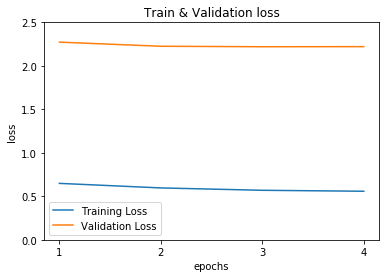

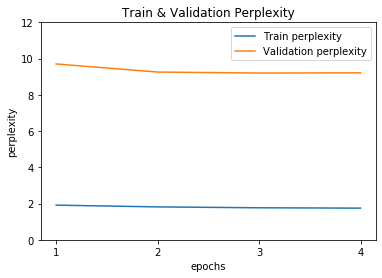

In [14]:
# Display Train & Validation loss and perplexity plots

fig= plot_train_val_loss(Test_4eps, "Train & Validation loss");
#fig.savefig(r'Figures\\Part1_GPT2\\train_val_loss_4eps.jpg')

fig= plot_train_val_perplexity(Test_4eps, "Train & Validation Perplexity");
#fig.savefig(r'Figures\\Part1_GPT2\\train_val_perplexity_4eps.jpg')

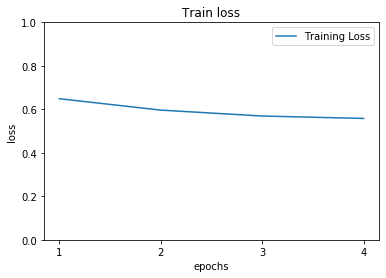

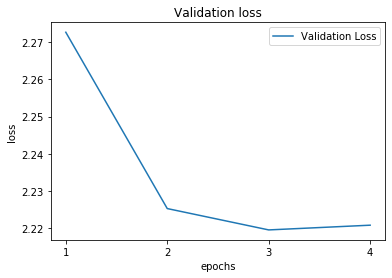

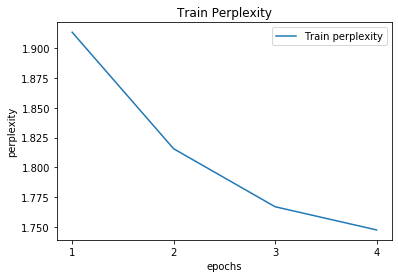

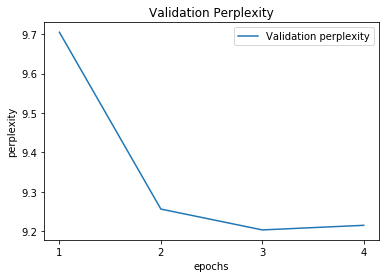

In [15]:
# Display plots individually for better scale:

# Plot train/val loss and perplexity
fig= plot_train_loss(Test_4eps, "Train loss");
#fig.savefig(r'Figures\\train_loss_4eps.jpg')

fig= plot_val_loss(Test_4eps, "Validation loss");
#fig.savefig(r'Figures\\val_loss_4eps.jpg')

fig= plot_train_perplexity(Test_4eps, "Train Perplexity");
#fig.savefig(r'Figures\\train_perplexity_4eps.jpg')

fig= plot_val_perplexity(Test_4eps, "Validation Perplexity");
#fig.savefig(r'Figures\\val_perplexity_4eps.jpg')


In [34]:
# Visualising the attention model for a data sample with tokens in Layer 1
# Note: Output does not save in file as it is a Javascript object, reload or view prints in Figures folder.

# Note: Double click on a colour block to filter for a specific attention head(12 in total for GPT-2)
input_id = dataset[255].to(device)
attention1=model(input_id)[-1]
attention=attention1[0]
input_id_list = input_id[0].tolist() 
tokens = tokenizer.convert_ids_to_tokens(input_id)
head_view(attention, tokens)

<IPython.core.display.Javascript object>

## Hyperparameter Tuning
### Exploring models trained for different epochs

In [58]:
# Load results from pickle files
Train_GPT2_4eps=pd.DataFrame(load_results("Results/GPT2/Train_GPT2_4eps.pickle"))
Train_GPT2_5eps=pd.DataFrame(load_results("Results/GPT2/Train_GPT2_5eps.pickle"))
Train_GPT2_10eps=pd.DataFrame(load_results("Results/GPT2/Train_GPT2_10eps.pickle"))
Train_GPT2_15eps=pd.DataFrame(load_results("Results/GPT2/Train_GPT2_15eps.pickle"))

# Results to dataframe
Frames= [Train_GPT2_4eps, Train_GPT2_5eps, Train_GPT2_10eps, Train_GPT2_15eps]
GPT2_Epochs=pd.concat(Frames)

In [60]:
# Load summary of result at the end of each epoch trained model e.g results after 5eps, 10 eps etc
GPT2_Epochs_summary = pd.DataFrame({},columns=GPT2_Epochs.columns)
current_epoch=GPT2_Epochs.iloc[0]['num_epochs']
for idx in range(1,len(GPT2_Epochs)):
    idx_epoch = GPT2_Epochs.iloc[idx]['num_epochs']
    if(idx_epoch!=current_epoch):
        GPT2_Epochs_summary = GPT2_Epochs_summary.append(GPT2_Epochs.iloc[idx-1],ignore_index=True)
        current_epoch = idx_epoch

if(GPT2_Epochs.iloc[len(GPT2_Epochs)-1]['num_epochs'] not in GPT2_Epochs_summary.num_epochs):   
    GPT2_Epochs_summary=GPT2_Epochs_summary.append(GPT2_Epochs.iloc[len(GPT2_Epochs)-1],ignore_index=True)

GPT2_Epochs_summary

,train_loss,val_loss,train_perplexity,val_perplexity,num_epochs
0,0.558411,2.234747,tensor(1.7479),tensor(9.3441),4
1,0.537192,2.237929,tensor(1.7112),tensor(9.3739),5
2,0.466798,2.294220,tensor(1.5949),tensor(9.9167),10
3,0.401522,2.408340,tensor(1.4941),tensor(11.1155),15


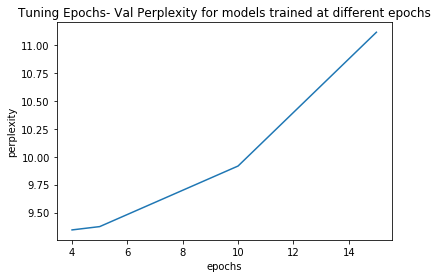

In [62]:
# Plot results by epoch
fig=plt.figure()
plt.plot(GPT2_Epochs_summary["num_epochs"],GPT2_Epochs_summary["val_perplexity"])
plt.xlabel("epochs")
plt.ylabel("perplexity")
plt.title("Tuning Epochs- Val Perplexity for models trained at different epochs")
plt.show();

# Validation loss and validation perplexity increases for models with additional training beyond 4eps
# Model is fully trained at 4eps as per standard GPT-2 documentation, will continue with a 4epoch model.


### Exploring gradient clipping during training

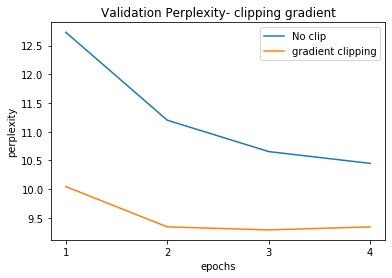

In [74]:
# Load results from pickle files
Train_GPT2_noclip=pd.DataFrame(load_results("Results/GPT2/Train_GPT2_4eps_noclip.pickle"))
Train_GPT2_clip=pd.DataFrame(load_results("Results/GPT2/Train_GPT2_4eps.pickle"))

# Plot results
fig=plt.figure()
epoch_count=range(1, len(Train_GPT2_clip['val_perplexity']) + 1)
plt.plot(epoch_count, Train_GPT2_noclip["val_perplexity"], label="No clip")
plt.plot(epoch_count, Train_GPT2_clip["val_perplexity"], label= "gradient clipping")
plt.xticks(epoch_count)
plt.xlabel("epochs")
plt.ylabel("perplexity")
plt.legend()
plt.title("Validation Perplexity- clipping gradient")
plt.show();

# Progress with clipping applied to gradients in train method

### Exploring optimiser learning rates

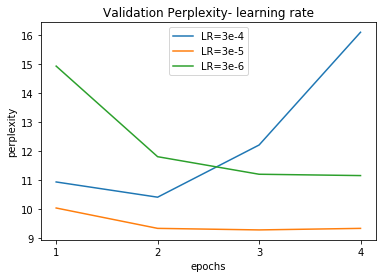

In [75]:
# Load results from pickle files

Train_GPT2_lr4=pd.DataFrame(load_results("Results/GPT2/Train_GPT2_4eps_lr4.pickle"))
Train_GPT2_lr5=pd.DataFrame(load_results("Results/GPT2/Train_GPT2_4eps.pickle"))
Train_GPT2_lr6=pd.DataFrame(load_results("Results/GPT2/Train_GPT2_4eps_lr6.pickle"))

# Plot results
fig=plt.figure()
epoch_count=range(1, len(Train_GPT2_lr4['val_perplexity']) + 1)
plt.plot(epoch_count, Train_GPT2_lr4["val_perplexity"], label="LR=3e-4")
plt.plot(epoch_count, Train_GPT2_lr5["val_perplexity"], label= "LR=3e-5")
plt.plot(epoch_count, Train_GPT2_lr6["val_perplexity"], label= "LR=3e-6")
plt.xticks(epoch_count)
plt.xlabel("epochs")
plt.ylabel("perplexity")
plt.legend()
plt.title("Validation Perplexity- learning rate")
plt.show();

# To progress with learning rate of 3e-5. 

# Evaluating fine-tuned GPT-2 model 

### Testing fine-tuned GPT-2 model

In [13]:

# Load final checkpoint for testing - 4eps trained model
load_checkpoint(model, optimizer=OPTIM, scheduler=SCHEDULER, load_checkpoint_path= "model_checkpoints\GPT-2\checkpoint_4.pth.tar")

Loading checkpoint ... 


(GPT2LMHeadModel(
   (transformer): GPT2Model(
     (wte): Embedding(50259, 768)
     (wpe): Embedding(1024, 768)
     (drop): Dropout(p=0.1, inplace=False)
     (h): ModuleList(
       (0): Block(
         (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         (attn): Attention(
           (c_attn): Conv1D()
           (c_proj): Conv1D()
           (attn_dropout): Dropout(p=0.1, inplace=False)
           (resid_dropout): Dropout(p=0.1, inplace=False)
         )
         (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         (mlp): MLP(
           (c_fc): Conv1D()
           (c_proj): Conv1D()
           (dropout): Dropout(p=0.1, inplace=False)
         )
       )
       (1): Block(
         (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         (attn): Attention(
           (c_attn): Conv1D()
           (c_proj): Conv1D()
           (attn_dropout): Dropout(p=0.1, inplace=False)
           (resid_dropout): Dropout(p=0.1, inplace=False)
  

In [14]:
test_run_4epsmodel= test_generate(model, tokenizer, dataloaders, device)


test loss: 2.221842, test ppl: 9.224304, bleu score default:0.2656753568899366, bleu score modified 1: 0.4619828416721334, bleu score modified 2: 0.5757232795300197


In [15]:
# Save results
#save_results(test_run_4epsmodel, "Results/GPT2/test_results_4eps.pickle")

In [16]:
# Load results
Test_GPT2_Results=pd.DataFrame(load_results("Results/GPT2/test_results_4eps.pickle"), index=[0])
Test_GPT2_Results


# BLEU modified scores relate to the weightings applied to the n_gram order weightings for n-gram orders (1,2,3,4) respectively:
# BLEU_score_default applies weightings=(0.25, 0.25,0.25,0.25)
# BLEU_score_modified1 applies weightings=(0.5, 0.25,0.25,0)
# BLEU_score_modified2 applies weightings=(0.5, 0.5,0,0)

# BLEU scores modified 1 & 2 penalise higher n_gram orders which is a more suitable approach for text generation 
# as compared to the default BLEU metric weightings classically used for machine translation evaluation

,mean_test_loss,mean_test_perplexity,bleu_score_default,bleu_score_modified1,bleu_score_modified2
0,2.221842,9.224304,0.265675,0.461983,0.575723


### Generate plot samples using fine-tuned GPT-2 for evaluation

In [17]:
# Generate 20 plot samples for human analysis and evaluation
set_seed()
test_samples= generate_text(model, tokenizer, device, num_samples=20) 
plot_samples_csv(test_samples, "results/generated_plots_10.csv")

print(*test_samples, sep="\n")


anime:Comic book writer, karaoke singer and comic book legend Haruo Murakawa takes up residence in a local high school, becoming one of the funniest students of all time.
romance:In an underground city, a couple unites around an uptight doctor who must find her a way home after discovering they are having sex in a nightclub.
children:As winter draws to a close, a mysterious stranger visits a deserted park and decides to show the park to her friends.
crime:This anthology series analyzes the culture of serial killers and the aftermath of the 2006 mass shooting at a gay nightclub.
anime:A new friend who happens to be a mysterious boy with extraordinary powers appears in this live-action adaptation of a popular popular manga.
romance:A married couple finds a woman as the husband they've always wanted – but a relationship has unexpected sides.
documentary:Using computer simulations, this documentary charts the progress of Indian tech giants from pioneering open source to modern day innovato

### Exploring Text Generation Parameters
#### Exploring outputs generated at different temperatures:

* Temperature of 1.1 selected for generation. The higher the temperature the higher the sensitivity to low probability word candidates for text generation which in essence results in more creative plots as can be evaluated below.

In [19]:
# Temperature tested at 1.1
set_seed()
test_temp= generate_text_tuning(model, tokenizer, device, num_samples=5, temperature=1.1, top_k=50, top_p=0.95) 

anime:Comic book writer, karaoke singer and comic book legend Haruo Murakawa takes up residence in a local high school, becoming one of the funniest students of all time.
romance:In an underground city, a couple unites around an uptight doctor who must find her a way home after discovering they are having sex in a nightclub.
children:As winter draws to a close, a mysterious stranger visits a deserted park and decides to show the park to her friends.
crime:This anthology series analyzes the culture of serial killers and the aftermath of the 2006 mass shooting at a gay nightclub.
anime:A new friend who happens to be a mysterious boy with extraordinary powers appears in this live-action adaptation of a popular popular manga.


In [20]:
# Temperature tested at 1
set_seed()
test_temp= generate_text_tuning(model, tokenizer, device, num_samples=5, temperature=1, top_k=50, top_p=0.95) 

anime:Comic book writer, karaoke singer and comic book legend Kiyotaka Kouko journeys into the past to tell her stories of love and struggle.
romance:Four friends in a dysfunctional marriage find love when they reunite with their father and grandfather as they juggle relationships and other issues.
children:The life of legendary hockey phenom Eddie Hall is impacted by his family and friendship with legendary Philadelphia Flyers captain Terry Brooks, whose journey to fame is captured in this comedy.
crime:The daughter of an architect is brutally murdered by two violent suspects, but her family tries to save their daughter's killer.
anime:A new generation of samurai fighting monsters must contend with rival gangs as they fight to keep their own ancient heritage alive.


In [21]:
# Temperature tested at 0.9
set_seed()
test_temp= generate_text_tuning(model, tokenizer, device, num_samples=5, temperature=0.9, top_k=50, top_p=0.95) 

anime:The fate of a single man is determined by the events of the last movie – including the mysterious death of his parents.
romance:An aspiring fashion designer with a long history of relationships enters a new marriage with an attractive but lonely woman.
children:After a car accident, a young boy becomes a celebrity on the streets of Paris. Can he help a girl he meets on a cruise to find the real deal?
crime:Sylvester Stallone must fight crime in this comedy about a cop who must overcome racism to avoid being pulled over for speeding.
anime:After a mysterious accident, a teenaged gamer teams up with a friend who can teach her about the power of video games.


# GPT-2 Vanilla - Evaluation & Testing
### Test vanilla GPT-2 without fine-tuning as a comparable baseline

In [13]:
test_vanilla= test_generate(model, tokenizer, dataloaders, device)


test loss: 85.763131, test ppl: 17638196934226003063694854122670915584.000000, bleu score default:0.09750728170975079, bleu score modified 1: 0.15920045508649847, bleu score modified 2: 0.19291238042567713


In [14]:
# Save results
#save_results(test_vanilla, "Results/GPT2/test_results_VANILLA.pickle")

In [15]:
# Vanilla GPT-2 generated samples example
test_samples= generate_text(model, tokenizer, device, num_samples=10) 
print(*test_samples, sep="\n")


anime: the "
, the "
, THE THE I I P C A G S H G A N
romance: sex with other than the father of the mother is a P E N S W I A
, 11
children: a a the of the of, and it, it I I   m m p p pp pl
crime: T the like it for to I
 and have that has not as with we, which is so about
anime: I I a a, an and, an and as as, --
 v t my
romance: end for the person has had used this to but that he would have done on I and so as by
documentary: " " for a my in and from I for and I from,, of of on to ), ]
crime: the - a the a - as an I
 as my my
 if if and,. and.
crime: " " '' - the '' the - a it, even a about about, even, and to some
action: the one should have been found on the Internet website site and so there might also be a of such this


# Part II: Fine-tuning BERT for classification

### Data pre-processing Netflix plot data for finetuning BERT

In [38]:
# Using the Netflix dataset previously loaded for GPT-2 finetuning and mapped to assigned genres

# Remove "other" genre from the dataset as it contains a mix of obscure genres relegated to an "other" category.
is_not_other= plot_dataset_df["genre"]!="other"
plot_dataset_filtered=plot_dataset_df[is_not_other].copy()

# Label-encode genres
plot_dataset_filtered["genre"] = plot_dataset_filtered["genre"].astype('category')
plot_dataset_filtered["genre_codes"] = plot_dataset_filtered['genre'].cat.codes

#View dataset
plot_dataset_filtered.head()

,genre,plot_description,genre_codes
0,international,In a future where the elite inhabit an island ...,8
1,drama,After a devastating earthquake hits Mexico Cit...,6
2,horror,"When an army recruit is found dead, his fellow...",7
3,action,"In a postapocalyptic world, rag-doll robots hi...",0
4,drama,A brilliant group of students become card-coun...,6


In [39]:
# Label and plot data for fine-tuning the BERT model
labels = plot_dataset_filtered.genre_codes.values
movie_plots = plot_dataset_filtered.plot_description.values


In [27]:
# DO NOT RUN- Tested additional step of stop words on data for improvement to training & validation - no improvement observed.
# Run performance saved as pickle file under results.

# stopwords = stopwords.words('english')
# plot_dataset_filtered["plot_description"] = [" ".join([word for word in sentence.lower().split() if word not in stopwords])
#                                              for sentence in plot_dataset_filtered["plot_description"].tolist()]
# movie_plots= plot_dataset_filtered.plot_description.values


### Loading and instantiating the BERT pretrained model from HuggingFace - BertForSequenceClassification

In [40]:
configuration = BertConfig.from_pretrained('bert-base-uncased', num_labels=plot_dataset_filtered["genre_codes"].max()+1)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',config=configuration)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### BERT Fine-tuning - Training & Validation

In [41]:
# Instantiating the raw Netflix Plot dataset for fine tuning BERT.
raw_bert_dataset = BertDataset(movie_plots, labels, tokenizer)

# Running a check example to visualise the BERT specific special tokens applied to the plot description data (input_id)
Example=raw_bert_dataset[20]
tokens= tokenizer.convert_ids_to_tokens(Example[0])
string=tokenizer.convert_tokens_to_string(tokens)
print(string)

[CLS] a successful writer returns to the town that launched his career , encountering people who spark nostalgic , often painfully illuminating flashbacks . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [42]:
# Split dataset and create dataloaders
dataloaders = split_datasets_and_create_dataloaders(raw_bert_dataset, batch_size=10)

Number of Training samples: 5021
Number of Validation samples: 1434
Number of Testing samples: 719


In [43]:
#Hyperparameters
EPOCHS=5
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)
device='cuda:0'

In [44]:
performance_bert= bert_train_val(model, dataloaders,starting_epoch=0, optimizer=OPTIM, scheduler=SCHEDULER, epochs=EPOCHS, device=device)



---------------
| TRAINING... |
---------------


Epoch:  1 / 5 Batch:  1 / 503 Loss:  2.073251485824585 Accuracy:  0.3
Epoch:  1 / 5 Batch:  101 / 503 Loss:  2.2526429195215205 Accuracy:  0.0
Epoch:  1 / 5 Batch:  201 / 503 Loss:  2.1273433231002654 Accuracy:  0.4
Epoch:  1 / 5 Batch:  301 / 503 Loss:  1.9771807126428598 Accuracy:  0.5
Epoch:  1 / 5 Batch:  401 / 503 Loss:  1.8583891470533356 Accuracy:  0.1
Epoch:  1 / 5 Batch:  501 / 503 Loss:  1.7644652818253417 Accuracy:  0.7

 epoch: 1, train loss: 1.763746, train accuracy: 0.381710, train time:00:01:14
Validating...



 epoch: 1, val loss: 1.334887, val accuracy: 0.527431, val_time: 00:00:05

Training Finished


Epoch:  2 / 5 Batch:  1 / 503 Loss:  1.2763993740081787 Accuracy:  0.6
Epoch:  2 / 5 Batch:  101 / 503 Loss:  1.1269429520805283 Accuracy:  0.6
Epoch:  2 / 5 Batch:  201 / 503 Loss:  1.1258405767269988 Accuracy:  0.4
Epoch:  2 / 5 Batch:  301 / 503 Loss:  1.1190786928037473 Accuracy:  0.5
Epoch:  2 / 5 Batch:  401 / 503 Loss:  1.1145665856668183 Accuracy:  0.6
Epoch:  2 / 5 Batch:  501 / 503 Loss:  1.1095141576911638 Accuracy:  0.2

 epoch: 2, train loss: 1.108986, train accuracy: 0.620278, train time:00:02:32
Validating...



 epoch: 2, val loss: 1.125259, val accuracy: 0.594792, val_time: 00:00:05

Training Finished


Epoch:  3 / 5 Batch:  1 / 503 Loss:  0.6468793153762817 Accuracy:  0.8
Epoch:  3 / 5 Batch:  101 / 503 Loss:  0.6954065174749582 Accuracy:  0.7
Epoch:  3 / 5 Batch:  201 / 503 Loss:  0.6611839631451896 Accuracy:  0.6
Epoch:  3 / 5 Batch:  301 / 503 Loss:  0.6392293760299287 Accuracy:  0.8
Epoch:  3 / 5 Batch:  401 / 503 Loss:  0.6235245074751669 Accuracy:  0.9
Epoch:  3 / 5 Batch:  501 / 503 Loss:  0.6188648895262007 Accuracy:  0.9

 epoch: 3, train loss: 0.617932, train accuracy: 0.801193, train time:00:03:50
Validating...



 epoch: 3, val loss: 1.237166, val accuracy: 0.597917, val_time: 00:00:05

Training Finished


Epoch:  4 / 5 Batch:  1 / 503 Loss:  0.15756335854530334 Accuracy:  1.0
Epoch:  4 / 5 Batch:  101 / 503 Loss:  0.2848395883373105 Accuracy:  0.8
Epoch:  4 / 5 Batch:  201 / 503 Loss:  0.29014595662850645 Accuracy:  1.0
Epoch:  4 / 5 Batch:  301 / 503 Loss:  0.2851046245805053 Accuracy:  1.0
Epoch:  4 / 5 Batch:  401 / 503 Loss:  0.2850286450255616 Accuracy:  0.9
Epoch:  4 / 5 Batch:  501 / 503 Loss:  0.2726823697647381 Accuracy:  0.9

 epoch: 4, train loss: 0.272036, train accuracy: 0.922465, train time:00:05:09
Validating...



 epoch: 4, val loss: 1.482367, val accuracy: 0.610417, val_time: 00:00:05

Training Finished


Epoch:  5 / 5 Batch:  1 / 503 Loss:  0.019268730655312538 Accuracy:  1.0
Epoch:  5 / 5 Batch:  101 / 503 Loss:  0.13483236790957429 Accuracy:  1.0
Epoch:  5 / 5 Batch:  201 / 503 Loss:  0.12414734709581629 Accuracy:  1.0
Epoch:  5 / 5 Batch:  301 / 503 Loss:  0.12707541065841318 Accuracy:  1.0
Epoch:  5 / 5 Batch:  401 / 503 Loss:  0.1249350718201656 Accuracy:  1.0
Epoch:  5 / 5 Batch:  501 / 503 Loss:  0.12199360284649445 Accuracy:  1.0

 epoch: 5, train loss: 0.121552, train accuracy: 0.968191, train time:00:06:27
Validating...



 epoch: 5, val loss: 1.685871, val accuracy: 0.612500, val_time: 00:00:05
Saving checkpoint ... 
Checkpoint: ./BERTcheckpoint_5.pth.tar saved.

Training Finished


In [33]:
# Save BERT finetuning results (loss and accuracy) to pickle file for quick load and comparison
# Note: model checkpoint saved within train method. 

#save_results(performance_bert, "Results/BERT/Train_original_5eps.pickle")


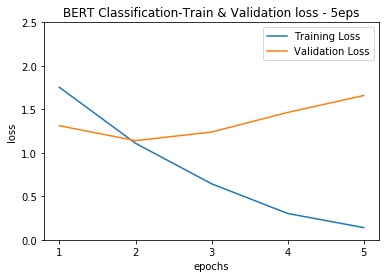

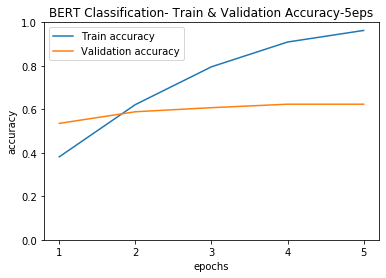

In [16]:
# Display Train & Validation loss and accuracy plots 

fig= plot_train_val_loss(performance_bert, "BERT Classification-Train & Validation loss - 5eps");
#fig.savefig(r'Figures\\Bert_train_val_loss_5eps_crop.jpg')

fig= plot_train_val_accuracy(performance_bert, "BERT Classification- Train & Validation Accuracy-5eps");
#fig.savefig(r'Figures\\Bert_train_val_accuracy_5eps_crop.jpg')

### Modifying BERT classifier for validation improvement

In [11]:
# Modifying BERTForSequenceClassification to include an additional linear layer for classification 

# Create new classifier
class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        
        self.fc1= nn.Linear(768, 512)
        self.fc2= nn.Linear(512, 10)
        
    def forward(self, x):
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)       
        return x

# Reloading the BERT model with modified classifier
        
modified_classifier= classifier()

configuration = BertConfig.from_pretrained('bert-base-uncased', num_labels=plot_dataset_filtered["genre_codes"].max()+1)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',config=configuration)
model.classifier= modified_classifier
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
# Train & validation modified BERT model
performance_bert_modified= bert_train_val(model, dataloaders,starting_epoch=0, optimizer=OPTIM, scheduler=SCHEDULER, epochs=EPOCHS, device=device)



---------------
| TRAINING... |
---------------


Epoch:  1 / 10 Batch:  1 / 503 Loss:  2.3383452892303467 Accuracy:  0.0
Epoch:  1 / 10 Batch:  101 / 503 Loss:  2.294849922161291 Accuracy:  0.1
Epoch:  1 / 10 Batch:  201 / 503 Loss:  2.2353581059631424 Accuracy:  0.3
Epoch:  1 / 10 Batch:  301 / 503 Loss:  2.1583168823457637 Accuracy:  0.4
Epoch:  1 / 10 Batch:  401 / 503 Loss:  2.0783080159874627 Accuracy:  0.1
Epoch:  1 / 10 Batch:  501 / 503 Loss:  1.9921447326561172 Accuracy:  0.7

 epoch: 1, train loss: 1.992632, train accuracy: 0.297416, train time:00:01:15
Validating...



 epoch: 1, val loss: 1.548190, val accuracy: 0.502778, val_time: 00:00:05

Training Finished


Epoch:  2 / 10 Batch:  1 / 503 Loss:  1.6074469089508057 Accuracy:  0.5
Epoch:  2 / 10 Batch:  101 / 503 Loss:  1.439388676445083 Accuracy:  0.5
Epoch:  2 / 10 Batch:  201 / 503 Loss:  1.415649221311161 Accuracy:  0.4
Epoch:  2 / 10 Batch:  301 / 503 Loss:  1.3874251541505225 Accuracy:  0.4
Epoch:  2 / 10 Batch:  401 / 503 Loss:  1.375167865705609 Accuracy:  0.6
Epoch:  2 / 10 Batch:  501 / 503 Loss:  1.3627122570416648 Accuracy:  0.2

 epoch: 2, train loss: 1.362829, train accuracy: 0.550696, train time:00:02:35
Validating...



 epoch: 2, val loss: 1.340759, val accuracy: 0.543403, val_time: 00:00:05

Training Finished


Epoch:  3 / 10 Batch:  1 / 503 Loss:  0.6599074006080627 Accuracy:  0.8
Epoch:  3 / 10 Batch:  101 / 503 Loss:  1.0704226673829673 Accuracy:  0.7
Epoch:  3 / 10 Batch:  201 / 503 Loss:  1.0318849194998765 Accuracy:  0.6
Epoch:  3 / 10 Batch:  301 / 503 Loss:  0.9906090714804754 Accuracy:  0.7
Epoch:  3 / 10 Batch:  401 / 503 Loss:  0.9848275510896174 Accuracy:  0.8
Epoch:  3 / 10 Batch:  501 / 503 Loss:  0.9769406934936128 Accuracy:  0.6

 epoch: 3, train loss: 0.974280, train accuracy: 0.680915, train time:00:03:55
Validating...



 epoch: 3, val loss: 1.299986, val accuracy: 0.568750, val_time: 00:00:05

Training Finished


Epoch:  4 / 10 Batch:  1 / 503 Loss:  0.7868397235870361 Accuracy:  0.7
Epoch:  4 / 10 Batch:  101 / 503 Loss:  0.6511158749903783 Accuracy:  0.5
Epoch:  4 / 10 Batch:  201 / 503 Loss:  0.6422401351566932 Accuracy:  1.0
Epoch:  4 / 10 Batch:  301 / 503 Loss:  0.6417028756682263 Accuracy:  0.8
Epoch:  4 / 10 Batch:  401 / 503 Loss:  0.6390189685373383 Accuracy:  0.7
Epoch:  4 / 10 Batch:  501 / 503 Loss:  0.62508837149261 Accuracy:  0.6

 epoch: 4, train loss: 0.623935, train accuracy: 0.805765, train time:00:05:16
Validating...



 epoch: 4, val loss: 1.351462, val accuracy: 0.595486, val_time: 00:00:05

Training Finished


Epoch:  5 / 10 Batch:  1 / 503 Loss:  0.03847571462392807 Accuracy:  1.0
Epoch:  5 / 10 Batch:  101 / 503 Loss:  0.3780911143426553 Accuracy:  1.0
Epoch:  5 / 10 Batch:  201 / 503 Loss:  0.3685708461486878 Accuracy:  0.8
Epoch:  5 / 10 Batch:  301 / 503 Loss:  0.3719709217115197 Accuracy:  1.0
Epoch:  5 / 10 Batch:  401 / 503 Loss:  0.36329912063561176 Accuracy:  0.9
Epoch:  5 / 10 Batch:  501 / 503 Loss:  0.35305341315676947 Accuracy:  0.9

 epoch: 5, train loss: 0.351825, train accuracy: 0.891252, train time:00:06:35
Validating...



 epoch: 5, val loss: 1.668825, val accuracy: 0.603472, val_time: 00:00:05

Training Finished


Epoch:  6 / 10 Batch:  1 / 503 Loss:  0.3914482295513153 Accuracy:  0.8
Epoch:  6 / 10 Batch:  101 / 503 Loss:  0.23749728852624793 Accuracy:  1.0
Epoch:  6 / 10 Batch:  201 / 503 Loss:  0.232795614466553 Accuracy:  1.0
Epoch:  6 / 10 Batch:  301 / 503 Loss:  0.24271277668715713 Accuracy:  0.8
Epoch:  6 / 10 Batch:  401 / 503 Loss:  0.23125623149839125 Accuracy:  0.9
Epoch:  6 / 10 Batch:  501 / 503 Loss:  0.22396108478460156 Accuracy:  1.0

 epoch: 6, train loss: 0.223457, train accuracy: 0.939165, train time:00:07:55
Validating...



 epoch: 6, val loss: 2.090078, val accuracy: 0.579167, val_time: 00:00:05

Training Finished


Epoch:  7 / 10 Batch:  1 / 503 Loss:  0.010119626298546791 Accuracy:  1.0
Epoch:  7 / 10 Batch:  101 / 503 Loss:  0.1241679477025893 Accuracy:  1.0
Epoch:  7 / 10 Batch:  201 / 503 Loss:  0.13586768341848432 Accuracy:  0.8
Epoch:  7 / 10 Batch:  301 / 503 Loss:  0.13969312632414652 Accuracy:  1.0
Epoch:  7 / 10 Batch:  401 / 503 Loss:  0.137222156780679 Accuracy:  1.0
Epoch:  7 / 10 Batch:  501 / 503 Loss:  0.12702180466269833 Accuracy:  1.0

 epoch: 7, train loss: 0.126529, train accuracy: 0.968390, train time:00:09:14
Validating...



 epoch: 7, val loss: 2.273597, val accuracy: 0.598611, val_time: 00:00:05

Training Finished


Epoch:  8 / 10 Batch:  1 / 503 Loss:  0.0019244358409196138 Accuracy:  1.0
Epoch:  8 / 10 Batch:  101 / 503 Loss:  0.044942470265109793 Accuracy:  1.0
Epoch:  8 / 10 Batch:  201 / 503 Loss:  0.0735182020134427 Accuracy:  0.9
Epoch:  8 / 10 Batch:  301 / 503 Loss:  0.08306560842428616 Accuracy:  1.0
Epoch:  8 / 10 Batch:  401 / 503 Loss:  0.08009031831380908 Accuracy:  1.0
Epoch:  8 / 10 Batch:  501 / 503 Loss:  0.08254898666169963 Accuracy:  1.0

 epoch: 8, train loss: 0.088585, train accuracy: 0.980119, train time:00:10:32
Validating...



 epoch: 8, val loss: 2.440914, val accuracy: 0.613889, val_time: 00:00:05

Training Finished


Epoch:  9 / 10 Batch:  1 / 503 Loss:  0.0014845682308077812 Accuracy:  1.0
Epoch:  9 / 10 Batch:  101 / 503 Loss:  0.05568448445324021 Accuracy:  1.0
Epoch:  9 / 10 Batch:  201 / 503 Loss:  0.05787238233030046 Accuracy:  1.0
Epoch:  9 / 10 Batch:  301 / 503 Loss:  0.055586486437939654 Accuracy:  0.9
Epoch:  9 / 10 Batch:  401 / 503 Loss:  0.05098292646880849 Accuracy:  1.0
Epoch:  9 / 10 Batch:  501 / 503 Loss:  0.0514684985491713 Accuracy:  1.0

 epoch: 9, train loss: 0.051272, train accuracy: 0.988270, train time:00:11:50
Validating...



 epoch: 9, val loss: 2.548276, val accuracy: 0.596528, val_time: 00:00:05

Training Finished


Epoch:  10 / 10 Batch:  1 / 503 Loss:  0.0015936391428112984 Accuracy:  1.0
Epoch:  10 / 10 Batch:  101 / 503 Loss:  0.026529319540569835 Accuracy:  1.0
Epoch:  10 / 10 Batch:  201 / 503 Loss:  0.02594396838830293 Accuracy:  1.0
Epoch:  10 / 10 Batch:  301 / 503 Loss:  0.031968001831838073 Accuracy:  1.0
Epoch:  10 / 10 Batch:  401 / 503 Loss:  0.028982566228017974 Accuracy:  1.0
Epoch:  10 / 10 Batch:  501 / 503 Loss:  0.0304979810161477 Accuracy:  1.0

 epoch: 10, train loss: 0.031555, train accuracy: 0.992048, train time:00:13:09
Validating...



 epoch: 10, val loss: 2.621454, val accuracy: 0.610417, val_time: 00:00:05
Saving checkpoint ... 
Checkpoint: ./BERTcheckpoint_10.pth.tar saved.

Training Finished


In [16]:
# Save results
save_results(performance_bert_modified, "Results/BERT/Train_modified_10eps.pickle")

## BERT- Evaluating & Predicting

#### Evaluating the classification of plots by genre for raw Netflix plot data vs GPT-2 generated data using our fine tuned BERT classifier

In [16]:
# Generating GPT-2 plot dataset for testing, equivalent in length to the raw test_dataset
# Will generate plots with same proportion of genre categories in the raw test_dataset, for effective comparison.

# Call the raw plot data test_loader
test_dataset_raw = dataloaders['test_dataloader']

# Extract a list of genres contained with the test_loader of the raw data
test_genre_list = []
for mydata in enumerate(test_dataset_raw):
    for genre_code in enumerate(mydata[1][2]):
        test_genre_list+=[plot_dataset_filtered[plot_dataset_filtered['genre_codes']==genre_code[1].item()].genre.to_list()[0]]


### Generate GPT-2 dataset using the test_genre_list as input genres. 
#### Note: uncomment the cell below to load the GPT-2 model checkpoint and regenerate the test_dataset, otherwise load from csv

In [17]:
# configuration = GPT2Config.from_pretrained('gpt2')
# configuration.pad_token_id = configuration.eos_token_id

# model_GPT2= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
# model_GPT2= model.to(device)
# model_GPT2.resize_token_embeddings(len(tokenizer))

# # Load checkpoint for GPT-2 model
# load_checkpoint(model, optimizer=OPTIM, scheduler=SCHEDULER, load_checkpoint_path= "model_checkpoints/GPT-2/checkpoint_4.pth.tar")

# # Generate GPT-2 test_dataset for BERT classification
# test_dataset_gpt2_generated=generate_text(model, tokenizer, device, num_samples=len(test_genre_list), input_genres=test_genre_list)

# # Save GPT-2 plot test_dataset to csv
#plot_samples_csv(test_dataset_gpt2_generated, "Data/GPT2_generated_data_classification/GPT2_classification_test_dataset.csv" )

In [45]:
# Load GPT-2 test_dataset for classification
test_dataset_gpt2_generated= pd.read_csv(os.path.join("Data/GPT2_generated_data_classification/GPT2_classification_test_dataset.csv") , encoding="utf8", header=None)
test_dataset_gpt2_generated["plot"]=test_dataset_gpt2_generated

# Process data to seperate label and plot
test_dataset_gpt2_generated['genre']=test_dataset_gpt2_generated['plot'].apply(lambda x: x[:x.find(":")])
test_dataset_gpt2_generated['plot_description']=test_dataset_gpt2_generated['plot'].apply(lambda x: x[x.find(":")+1:])

# Sense check
dataset_gpt2_generated=test_dataset_gpt2_generated[['genre','plot_description']].copy()
dataset_gpt2_generated.head()


,genre,plot_description
0,comedy,A successful film director is faced with the t...
1,action,In this adaptation of Frank Sinatra's classic ...
2,drama,When an old classmate is caught in a crossfire...
3,drama,When a woman and a girl from a neighboring tow...
4,comedy,The biggest laughs come during this all-import...


In [46]:
# Label-encode genres
dataset_gpt2_generated["genre"] = dataset_gpt2_generated["genre"].astype('category')
dataset_gpt2_generated["genre_codes"] = dataset_gpt2_generated['genre'].cat.codes

# GPT-2 Label and plot data for testing
labels_gpt2 = dataset_gpt2_generated.genre_codes.values
movie_plots_gpt2 = dataset_gpt2_generated.plot_description.values

In [47]:
# Instantiate the gpt2 test_dataset via BertDataset processing
netflix_dataset_gpt2 = BertDataset( movie_plots=movie_plots_gpt2, labels=labels_gpt2, tokenizer=tokenizer)

# Create a dataloader for the dataset
netflix_gpt2_dataloader= DataLoader(netflix_dataset_gpt2, batch_size=10, shuffle=False)


## Evaluate Netflix plot data vs GPT-2 generated plot data on fine-tuned BERT


In [48]:
raw_performance, raw_predictions_list, raw_labels_list=evaluate_classifier(model, dataloader=dataloaders["test_dataloader"], device=device)


 test accuracy: 0.620306


In [49]:
GPT2_performance, GPT2_predictions_list, GPT2_labels_list=evaluate_classifier(model, dataloader=netflix_gpt2_dataloader, device=device)


 test accuracy: 0.524339


In [23]:
# Save results to pickle file
#save_results(raw_performance, "Results/BERT/Test_raw_5epsmodel.pickle")
#save_results(GPT2_performance, "Results/BERT/Test_GPT2_5epsmodel.pickle")

In [50]:
# Load results for comparison
Netflix_raw_results= load_results("Results/BERT/Test_raw_5epsmodel.pickle")
print("Netflix_raw_results")
print(Netflix_raw_results)


GPT2_results= load_results("Results/BERT/Test_GPT2_5epsmodel.pickle")
print("GPT2_results")
print(GPT2_results)

Netflix_raw_results
{'test_accuracy': tensor(0.6273, device='cuda:0')}
GPT2_results
{'test_accuracy': tensor(0.5271, device='cuda:0')}


### Visualise test results

In [51]:
# Classification report for Netflix original data test
raw_plot_metrics=classification_metrics(predictions=raw_predictions_list, labels=raw_labels_list)
print(raw_plot_metrics)

              precision    recall  f1-score   support

           0       0.41      0.54      0.46        61
           1       0.50      0.73      0.59        11
           2       0.77      0.73      0.75        85
           3       0.63      0.65      0.64       150
           4       0.52      0.43      0.47        37
           5       0.88      0.84      0.86       114
           6       0.55      0.54      0.54       148
           7       0.54      0.71      0.61        21
           8       0.53      0.44      0.48        89
           9       0.00      0.00      0.00         3

    accuracy                           0.62       719
   macro avg       0.53      0.56      0.54       719
weighted avg       0.62      0.62      0.62       719



In [52]:
# Classification report for GPT2 data test
gpt2_plot_metrics=classification_metrics(predictions=GPT2_predictions_list, labels=GPT2_labels_list)
print(gpt2_plot_metrics)

              precision    recall  f1-score   support

           0       0.33      0.54      0.41        61
           1       0.38      0.27      0.32        11
           2       0.71      0.60      0.65        85
           3       0.65      0.51      0.57       150
           4       0.33      0.24      0.28        37
           5       0.77      0.75      0.76       114
           6       0.50      0.55      0.52       148
           7       0.37      0.52      0.43        21
           8       0.30      0.29      0.29        89
           9       0.00      0.00      0.00         3

    accuracy                           0.52       719
   macro avg       0.43      0.43      0.42       719
weighted avg       0.54      0.52      0.53       719



In [27]:
# Generate confusion matrix to visualise predictions and compare between both test datasets
raw_CM= confusion_matrix(predictions=raw_predictions_list, labels=raw_labels_list)
GPT2_CM= confusion_matrix(predictions=GPT2_predictions_list, labels=GPT2_labels_list)

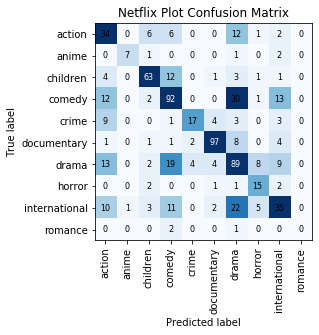

In [28]:
# Plot Confusion Matrix
plot_confusion_matrix(raw_CM, "Netflix Plot Confusion Matrix");

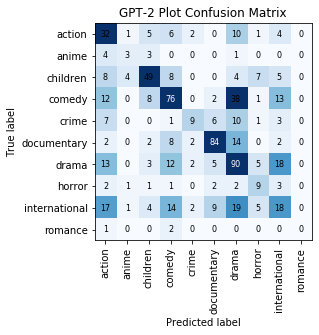

In [29]:
# Plot Confusion Matrix
plot_confusion_matrix(GPT2_CM, "GPT-2 Plot Confusion Matrix");

In [33]:
# Matthews Correlation Coefficient

netflix_data= matthews_CC_score(raw_labels_list, raw_predictions_list)
print("netflix:")
print(netflix_data)
gpt2_data= matthews_CC_score(GPT2_labels_list, GPT2_predictions_list)
print("gpt2:")
print(gpt2_data)

netflix:
0.5578650858164375
gpt2:
0.42942447961017166


## Evaluate using BERT Vanilla

In [41]:
# Evaluate test_datasets using BERT vanilla for a baseline comparison of classification

configuration = BertConfig.from_pretrained('bert-base-uncased', num_labels=plot_dataset_filtered["genre_codes"].max()+1)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',config=configuration)
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [42]:
raw_performance_vanilla, raw_predictions_list_vanilla, raw_labels_list_vanilla=evaluate_classifier(model, dataloader=dataloaders["test_dataloader"], device=device)



 test accuracy: 0.051460


In [43]:
GPT2_performance_vanilla, GPT2_predictions_list_vanilla, GPT2_labels_list_vanilla=evaluate_classifier(model, dataloader=netflix_gpt2_dataloader, device=device)


 test accuracy: 0.051460


In [44]:
# Save results to pickle file
save_results(raw_performance_vanilla, "Results/BERT/Vanilla_test_raw.pickle")
save_results(GPT2_performance_vanilla, "Results/BERT/Vanilla_test_GPT2.pickle")